# Descriptive Statistics of Papers and Networks


In [4]:
# inline
%matplotlib inline

import os
import statistics
from dotenv import load_dotenv
import pandas as pd
import seaborn as sns

# Load environment variables from .env file
load_dotenv()

# Access environment variables
python_path = os.getenv('PYTHONPATH')
data_dir = os.getenv('DATA_DIR')
src_dir = os.getenv('SRC_DIR')
output_dir = os.getenv('OUTPUT_DIR')

In [6]:
p = data_dir + "/04-embeddings/df_with_specter2_embeddings.pkl"

df = pd.read_pickle(p)

# Descriptives of Papers per Year


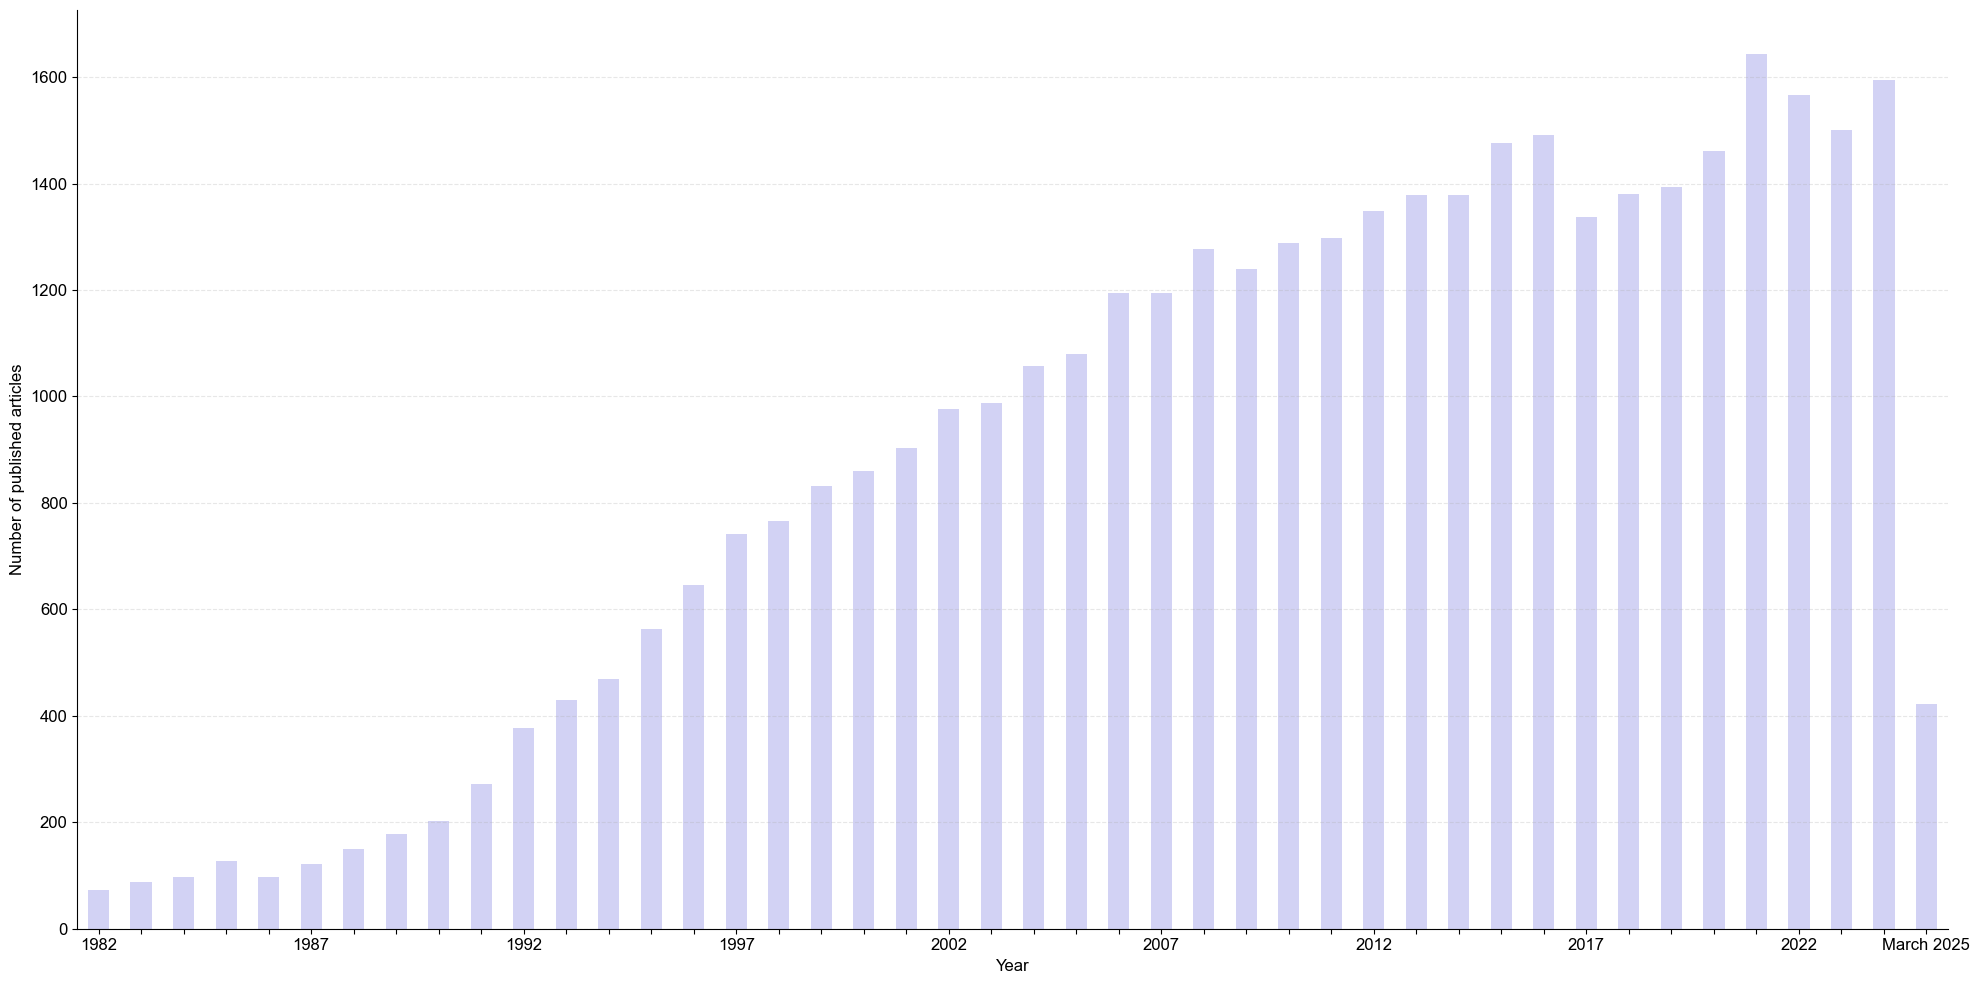

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker

# Set font size and family
plt.rcParams.update({"font.size": 12})
plt.rcParams.update({"font.family": "Arial"})

# Plot the average number of references in a year
plt.figure(figsize=(12, 6))
df["year"] = df["year"].astype(int)
year_counts = df["year"].value_counts().sort_index()

ax = year_counts.plot(kind="bar", figsize=(20, 10), color="#D2D2F4")

# Get the years from the index
years = year_counts.index.tolist()

# Create new labels - show every other year, change last to "March 2025"
new_labels = []
for i, year in enumerate(years):
    if i == len(years) - 1:  # Last position
        new_labels.append("March 2025")
    elif i % 5 == 0:  # Show every other year starting from first
        new_labels.append(str(year))
    else:
        new_labels.append("")

# Set ticks and labels together
ax.set_xticks(range(len(years)))
ax.set_xticklabels(new_labels, rotation=0, ha="center")

# Set labels
plt.xlabel("Year")
plt.ylabel("Number of published articles")

plt.grid(axis="y", linestyle="--", alpha=0.3)
sns.despine(top=True, right=True)
plt.tight_layout()
plt.savefig(output_dir + "/figures/articles_per_year_2025.png", dpi=300)
plt.show()

# Total number of referenced articles


# Number of references per paper per year


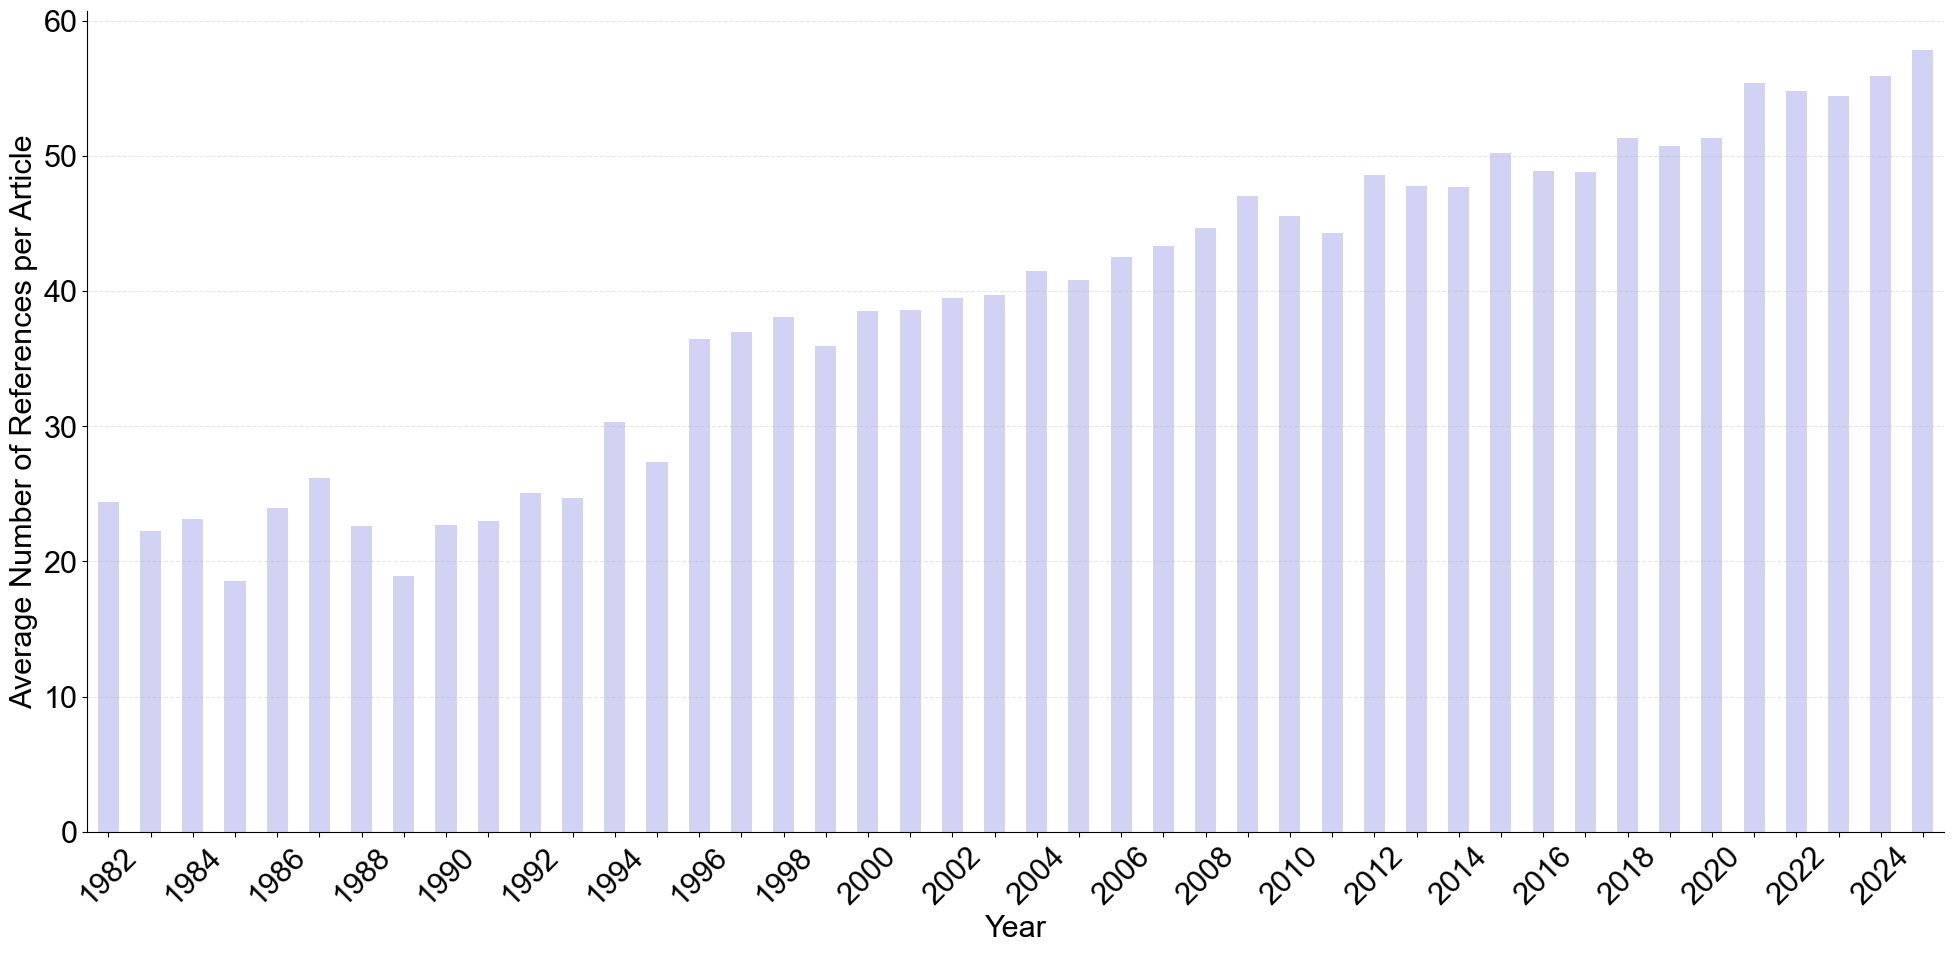

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker

# Set font size and family
plt.rcParams.update({"font.size": 22})
plt.rcParams.update({"font.family": "Arial"})

# Group the DataFrame by the "year" column and calculate the mean of "nr_references" for each year
average_references_by_year = df.groupby("year")["nr_references"].mean()

# Plot the average number of references in a year
plt.figure(figsize=(20, 10))
ax = average_references_by_year.plot(
    kind="bar",
    xlabel="Year",
    ylabel="Average Number of Cited Articles",
    color="#D2D2F4",
)
# Show every other x tick
for label in ax.get_xticklabels()[1::2]:
    label.set_visible(False)  # Set every other tick label invisible

# Set labels
plt.xlabel("Year")
plt.ylabel("Average Number of References per Article")

plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.3)
sns.despine(top=True, right=True)
plt.tight_layout()
plt.savefig(output_dir + "/figures/total_average_references_by_year2025.png", dpi=300)
plt.show()

# Number of references per paper within Dataset


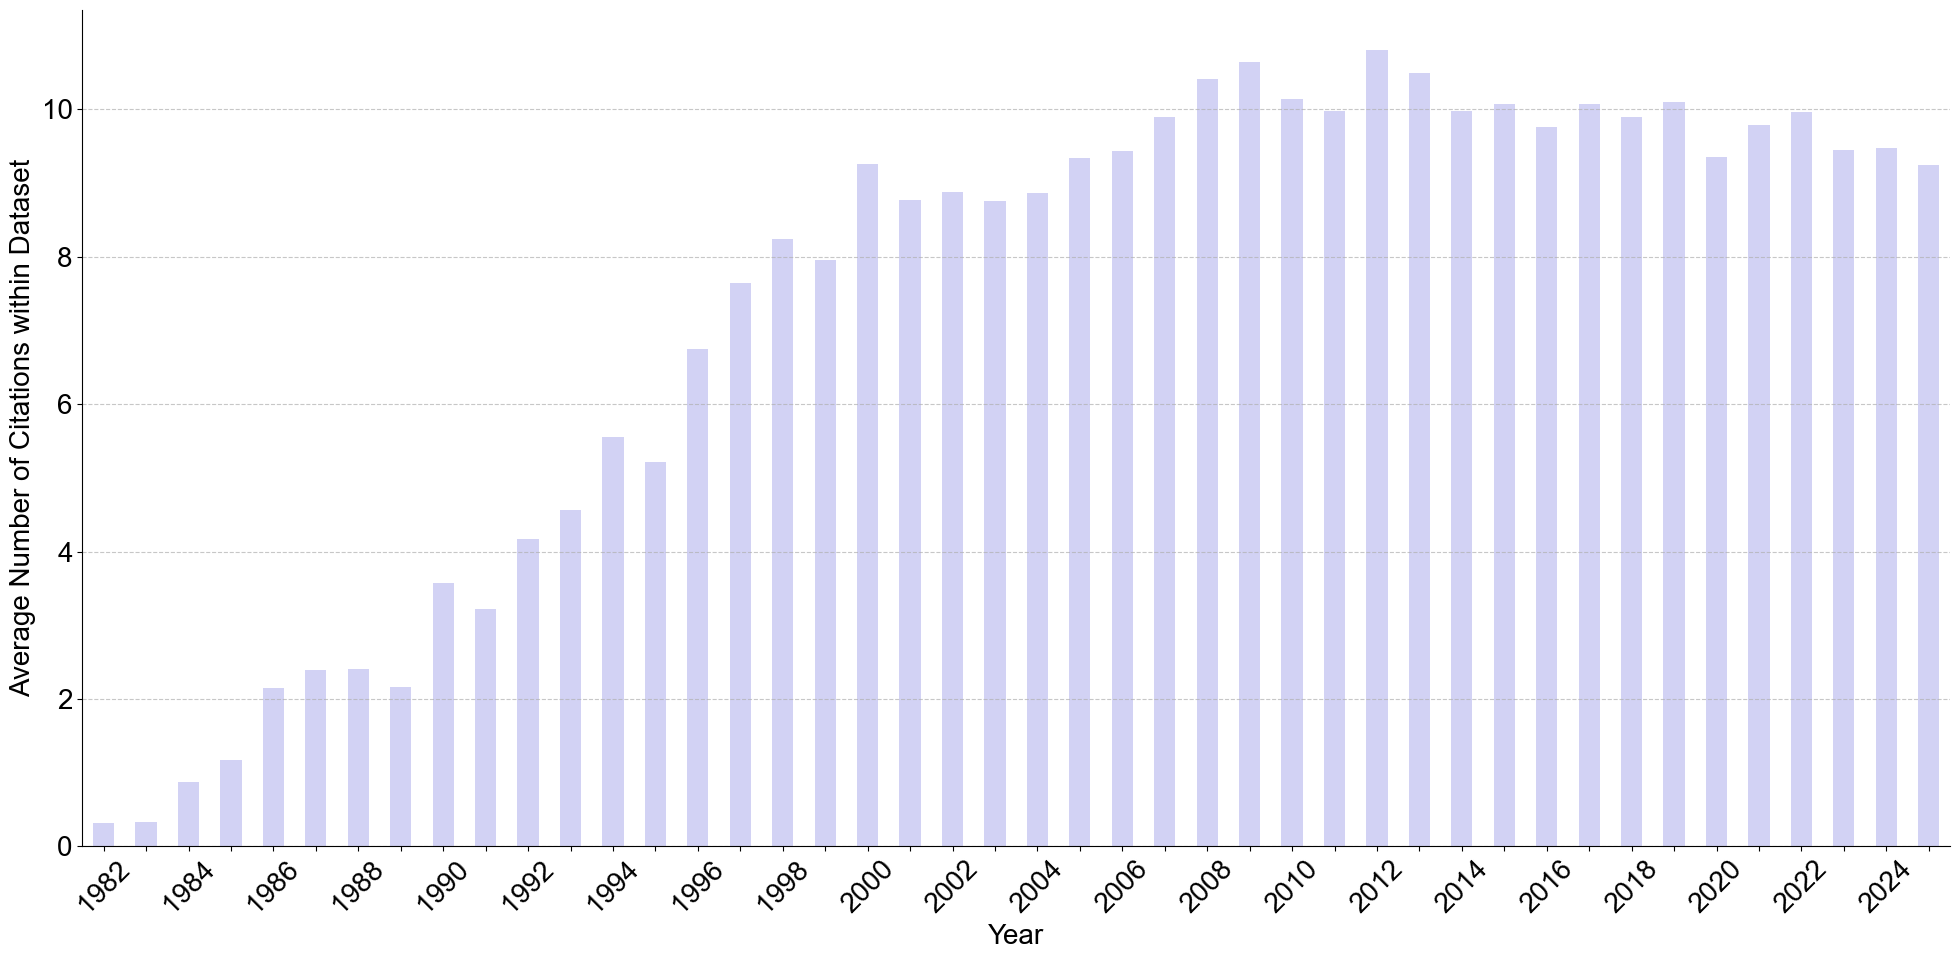

In [23]:
# use aria, font size 11
plt.rcParams.update({"font.size": 20})
plt.rcParams.update({"font.family": "Arial"})
# plot the average number of filtered references in a year
average_filtered_references_by_year = df.groupby("year")[
    "nr_filtered_references"
].mean()
plt.figure(figsize=(20, 10))
ax = average_filtered_references_by_year.plot(
    kind="bar",
    xlabel="Year",
    ylabel="Average Number of Citations within Dataset",
    color="#D2D2F4",
)

for label in ax.get_xticklabels()[1::2]:
    label.set_visible(False)  # Set every other tick label invisible

# rotate xticks
plt.xticks(rotation=45)
# plt.title("Average Number of Filtered References in a Year")
plt.grid(axis="y", linestyle="--", alpha=0.7)
# remove top and right spines
sns.despine(top=True, right=True)
plt.tight_layout()
plt.savefig(
    output_dir + "/figures/filtered_average_references_by_year2025.png", dpi=300
)
plt.show()

# Descriptives of the text


### Abstract lenghts per year


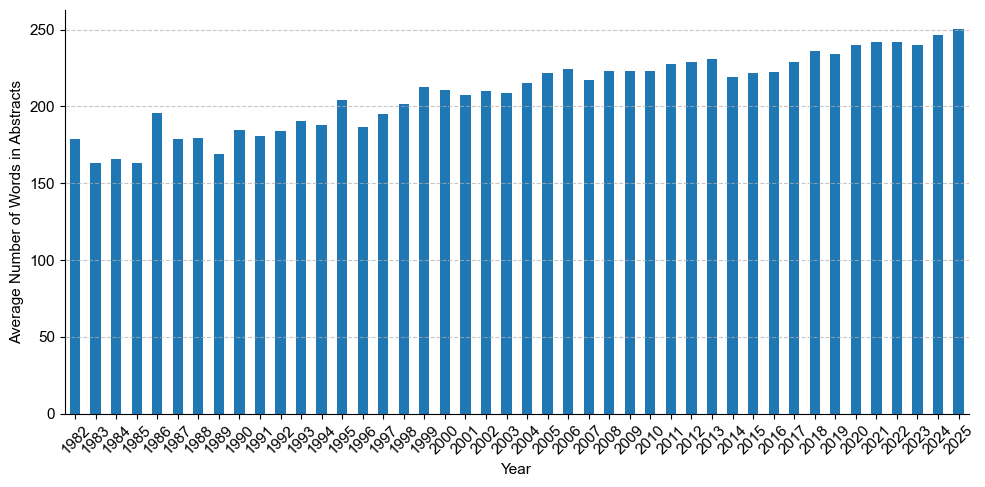

In [25]:
# use aria, font size 11
plt.rcParams.update({"font.size": 11})
plt.rcParams.update({"font.family": "Arial"})

# Group the DataFrame by the "year" column and calculate the mean of "nr_references" for each year
average_abs_lengths = df.groupby("year")["tokenized_abstracts_lens"].mean()

# Plot the average number of references in a year
plt.figure(figsize=(10, 5))
average_abs_lengths.plot(
    kind="bar", xlabel="Year", ylabel="Average Number of Words in Abstracts"
)
plt.xticks(rotation=45)
# plt.title("Average Number of References in a Year")
plt.grid(axis="y", linestyle="--", alpha=0.7)
sns.despine(top=True, right=True)
plt.tight_layout()
plt.savefig(output_dir + "/figures/average_abs_lengths2025.png", dpi=300)
plt.show()

# Descriptives of networks


In [26]:
import networkx as nx

In [27]:
# directed citation graph
p = data_dir + "/05-graphs/2025/citation-graph/directed_citation_graph.graphml"
G_dc = nx.read_graphml(p)

In [28]:
class NetworkDescriptives:
    def __init__(self, G):
        self.G = G
        self.directed = G.is_directed()
        print(f"Directed: {self.directed}")

    def basic_stats(self):
        """
        # (0-1 value;)
        # clustering coefficient is the average of the local clustering coefficient over all nodes in the graph
        # Local Clustering Coefficient: This measures how close a node's neighbors are to being a complete graph (clique). For a given node, it is the ratio of existing connections among its neighbors to all possible connections among them. (node a cites node b and c, but b and c do not cite each other)

        Calculate basic statistics of the network.

        Returns:
            A dictionary with the number of nodes, number of edges, network density,
            and average clustering coefficient.
        """
        stats = {
            "number_of_nodes": self.G.number_of_nodes(),
            "number_of_edges": self.G.number_of_edges(),
            "density": nx.density(self.G),
            "average_clustering_coefficient": nx.average_clustering(self.G),
        }

        return stats

    def in_out_degree(self):
        """
        Calculate and return summary statistics for in-degree and out-degree of the network.
        First establish the directedness of the graph, then calculate the in-degree and out-degree.

        Returns:
            A dictionary containing minimum, maximum, mean, and median for both in-degree and out-degree.
        """
        if self.directed:  # Remove parentheses from self.directed
            in_degrees = [deg for _, deg in self.G.in_degree()]
            out_degrees = [deg for _, deg in self.G.out_degree()]

            metrics = {
                "indegree": {
                    "min": min(in_degrees),
                    "max": max(in_degrees),
                    "mean": statistics.mean(in_degrees),
                    "median": statistics.median(in_degrees),
                    "range": f"{min(in_degrees)} to {max(in_degrees)}",
                },
                "outdegree": {
                    "min": min(out_degrees),
                    "max": max(out_degrees),
                    "mean": statistics.mean(out_degrees),
                    "median": statistics.median(out_degrees),
                    "range": f"{min(out_degrees)} to {max(out_degrees)}",
                },
            }
        else:
            degrees = [deg for _, deg in self.G.degree()]
            metrics = {
                "degree": {
                    "min": min(degrees),
                    "max": max(degrees),
                    "mean": statistics.mean(degrees),
                    "median": statistics.median(degrees),
                    "range": f"{min(degrees)} to {max(degrees)}",
                }
            }

        return metrics

    def connected_components(self):
        """
        Calculate and return various connected component metrics of the network.

        Returns:
            A dictionary with the number of strongly and weakly connected components,
            the size of the largest strongly connected component (GCC),
            and the size of the largest weakly connected component.
        """
        # Strongly connected components
        sccs = list(nx.strongly_connected_components(self.G))
        largest_scc_size = len(max(sccs, key=len))

        # Weakly connected components
        wccs = list(nx.weakly_connected_components(self.G))
        largest_wcc_size = len(max(wccs, key=len))

        # Compile metrics into a dictionary for clarity and extensibility
        metrics = {
            "num_strongly_connected_components": len(sccs),
            "largest_strongly_connected_component_size": largest_scc_size,
            "num_weakly_connected_components": len(wccs),
            "largest_weakly_connected_component_size": largest_wcc_size,
        }

        return metrics

    def main(self):
        """
        Calculate and return all network descriptives.

        Returns:
            A dictionary containing basic statistics, in-degree and out-degree summary statistics,
            and connected component metrics.
        """
        descriptives = {
            "basic_statistics": self.basic_stats(),
            "in_out_degree": self.in_out_degree(),
        }
        if self.directed:  # Remove parentheses from self.directed()
            descriptives["connected_components"] = self.connected_components()

        return descriptives

# Directed Network Descriptives


In [29]:
import json

descriptives_dc = NetworkDescriptives(G_dc).main()
# save to json
with open(
    output_dir
    + "/tables/descriptives/network_direct_citations_descriptives_20250401.json",
    "w",
) as f:
    json.dump(descriptives_dc, f, indent=4)
descriptives_dc

Directed: True


{'basic_statistics': {'number_of_nodes': 38961,
  'number_of_edges': 355263,
  'density': 0.0002340458449288018,
  'average_clustering_coefficient': 0.07960445495061212},
 'in_out_degree': {'indegree': {'min': 0,
   'max': 720,
   'mean': 9.118426118426118,
   'median': 3,
   'range': '0 to 720'},
  'outdegree': {'min': 0,
   'max': 274,
   'mean': 9.118426118426118,
   'median': 6,
   'range': '0 to 274'}},
 'connected_components': {'num_strongly_connected_components': 38833,
  'largest_strongly_connected_component_size': 19,
  'num_weakly_connected_components': 2214,
  'largest_weakly_connected_component_size': 36677}}

# Hybrid Network


In [30]:
# directed citation graph
p = (
    data_dir
    + "/05-graphs/2025/weighted-knn-citation-graph/weighted_alpha0.3_k10_knn_citation_20250401.graphml"
)
G_hybrid = nx.read_graphml(p)

In [31]:
descriptives_hybrid = NetworkDescriptives(G_hybrid).main()

# save to json
with open(
    output_dir
    + "/tables/descriptives/network_hybrid_descriptives_alpha0.3_k10_20250401.json",
    "w",
) as f:
    json.dump(descriptives_dc, f, indent=4)

descriptives_hybrid

Directed: False


{'basic_statistics': {'number_of_nodes': 38961,
  'number_of_edges': 584576,
  'density': 0.0007702326661943363,
  'average_clustering_coefficient': 0.20377133555357788},
 'in_out_degree': {'degree': {'min': 9,
   'max': 730,
   'mean': 30.008264674931343,
   'median': 23,
   'range': '9 to 730'}}}

In [32]:
# directed citation graph
p = (
    data_dir
    + "/05-graphs/2025/weighted-knn-citation-graph/weighted_alpha0.3_k20_knn_citation_20250401.graphml"
)
G_hybrid = nx.read_graphml(p)

descriptives_hybrid = NetworkDescriptives(G_hybrid).main()

# save to json
with open(
    output_dir
    + "/tables/descriptives/network_hybrid_descriptives_alpha0.3_k20_20250401.json",
    "w",
) as f:
    json.dump(descriptives_dc, f, indent=4)

descriptives_hybrid

Directed: False


{'basic_statistics': {'number_of_nodes': 38961,
  'number_of_edges': 868192,
  'density': 0.0011439228413903295,
  'average_clustering_coefficient': 0.2259436058994283},
 'in_out_degree': {'degree': {'min': 19,
   'max': 733,
   'mean': 44.56723390056723,
   'median': 35,
   'range': '19 to 733'}}}

In [33]:
# directed citation graph
p = (
    data_dir
    + "/05-graphs/2025/weighted-knn-citation-graph/weighted_alpha0.3_k15_knn_citation_20250401.graphml"
)
G_hybrid = nx.read_graphml(p)

descriptives_hybrid = NetworkDescriptives(G_hybrid).main()

# save to json
with open(
    output_dir
    + "/tables/descriptives/network_hybrid_descriptives_alpha0.3_k15_20250401.json",
    "w",
) as f:
    json.dump(descriptives_dc, f, indent=4)

descriptives_hybrid

Directed: False


{'basic_statistics': {'number_of_nodes': 38961,
  'number_of_edges': 725050,
  'density': 0.0009553200860524611,
  'average_clustering_coefficient': 0.21624830724448596},
 'in_out_degree': {'degree': {'min': 14,
   'max': 732,
   'mean': 37.21927055260389,
   'median': 29,
   'range': '14 to 732'}}}